# Zonal Analysis

In [ ]:
import contextily as cx
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import rasterio as rio
import swisslandstats as sls
from shapely.geometry import Point

import pylandstats as pls

Landscapes tend to be heterogeneous and complex and therefore reducing such information to a single scalar value for all the landscape often leads to metric values that are hard to interpret. It might thus be helpful to decompose the landscape into a set of zones of interest and compute the metrics for each zone separatedly. Such approach to GIS is often referred to as zonal analysis. The pylandstats library features three classes that might be used to that end: the more generic `ZonalAnalysis`, `BufferAnalysis` and `ZonalGridAnalysis`.

We first need to run the cell below so that:
- the land use/land cover (LULC) data is downloaded and preprocessed (see [A03-swisslandstats-preprocessing.ipynb](https://github.com/martibosch/pylandstats-notebooks/blob/main/notebooks/A03-swisslandstats-preprocessing.ipynb) for more details).
- the elevation zones vector data is downloaded and preprocessed (see [A04-elev-zones.ipynb](https://github.com/martibosch/pylandstats-notebooks/blob/main/notebooks/A04-elev-zones.ipynb) for more details).

In [ ]:
!snakemake -c1 -d .. -s ../Snakefile veveyse_lulc_tifs elev_zones

Building DAG of jobs...
Nothing to be done (all requested files are present and up to date).
Complete log: .snakemake/log/2024-07-25T194015.420105.snakemake.log


Consider the following landscape of the District of the Veveyse, Switzerland:

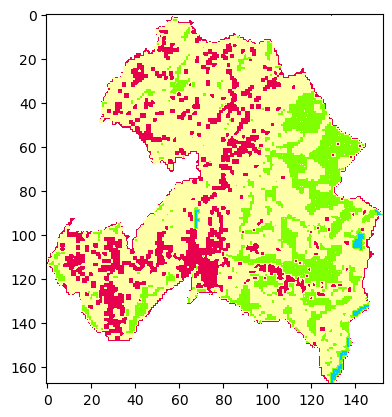

In [ ]:
URBAN_CLASS_VAL = 1
input_filepath = "../data/processed/veveyse/AS18_4.tif"

with rio.open(input_filepath) as src:
    plt.imshow(src.read(1), cmap=sls.noas04_4_cmap, norm=sls.noas04_4_norm)

## Zonal analysis

The `ZonalAnalysis` class of PyLandStats serves to compute the landscape metrics over any set of zones. Instantiating a `ZonalAnalysis` requires two positional arguments, namely the landscape file and the zones, which can be defined by means of vector geometries or a labelled array of the same form as the landscape (i.e., mapping each landscape pixel to its zone).

### Using vector geometries to define zones

The most straight-forward way to define a zonal analysis is to use a geopandas geo-series or geo-data frame or its equivalent file-like object. In this example, we will use a geopackage file defining a set of elevation zones. Additionally, we will use the `zone_index` argument to indicate which column of the geopackage file will be used to index the zones:

In [ ]:
elev_zones_filepath = "../data/processed/elev-zones.gpkg"

za = pls.ZonalAnalysis(input_filepath, elev_zones_filepath, zone_index="elev-zone")

The `ZonalAnalysis` instance will automatically generate the three landscapes of interest (one for each transect) by masking the pixels of the input raster. Such information is stored as part of the `zone_gser` attribute:

In [ ]:
za.zone_gser

elev-zone
<1000        MULTIPOLYGON (((2560900.000 1150500.000, 25607...
1000-1500    POLYGON ((2563900.000 1160700.000, 2563900.000...
>1500        MULTIPOLYGON (((2566300.000 1151500.000, 25665...
Name: geometry, dtype: geometry

We can also plot the `zone_gser` attribute to visualize the zones (we are resetting the index so that we can use it as color scheme) with a basemap (obtained using the [contextily](https://github.com/geopandas/contextily) library):

/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


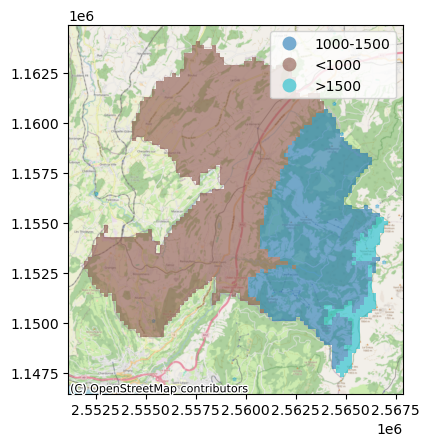

In [ ]:
ax = za.zone_gser.reset_index().plot(
    "elev-zone", alpha=0.6, categorical=True, legend=True
)
cx.add_basemap(ax, crs=za.zone_gser.crs, source=cx.providers.OpenStreetMap.Mapnik)

Similarly, we can visualize the landscape rasters of each zone by means of the `plot_landscapes` method as in:

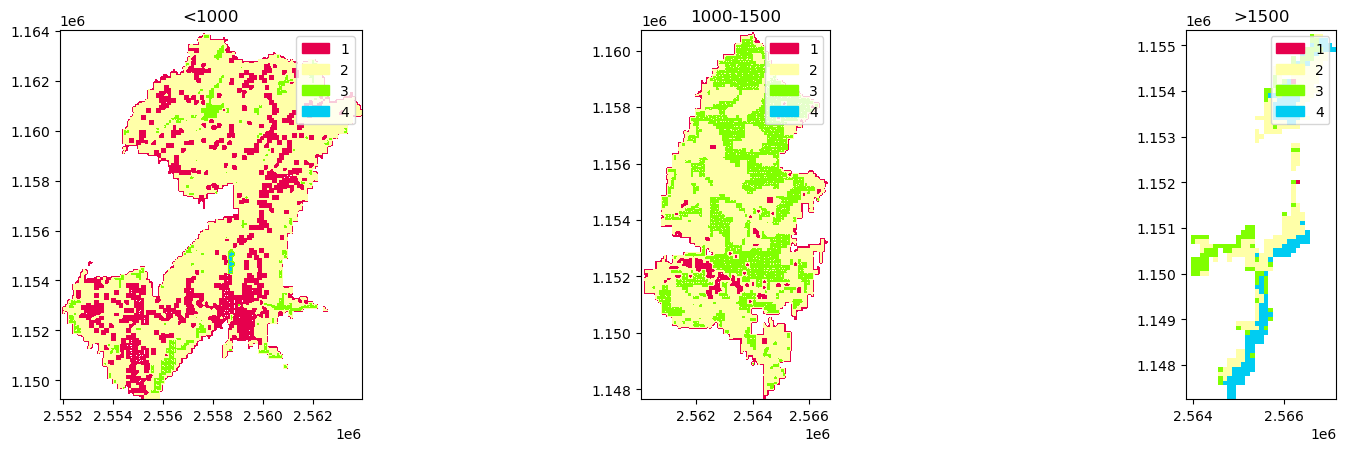

In [ ]:
fig = za.plot_landscapes(
    cmap=sls.noas04_4_cmap, show_kwargs=dict(norm=sls.noas04_4_norm)
)

The goal is now to compute and plot the landscape metrics for each zone. Like `SpatioTemporalAnalysis`, `ZonalAnalysis` only supports class and landscape-level metrics, which again, can be computed by means of its methods `compute_class_metrics_df` and `compute_landscape_metrics_df` respectively, e.g.:

In [ ]:
za.compute_class_metrics_df()

[##########################              ] | 66% Completed | 2.02 sms

/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[########################################] | 100% Completed | 2.12 s


total_area  proportion_of_landscape  number_of_patches  \
class_val elev-zone                                                           
1         <1000           911.0                11.212308                232   
          1000-1500       117.0                 2.564103                 49   
          >1500             2.0                 0.421941                  2   
2         <1000          5621.0                69.181538                 29   
          1000-1500      1602.0                35.108481                 55   
          >1500           221.0                46.624473                 12   
3         <1000          1530.0                18.830769                226   
          1000-1500      2795.0                61.253561                 36   
          >1500           104.0                21.940928                 24   
4         <1000            63.0                 0.775385                 27   
          1000-1500        49.0                 1.073855                 35   
          >1500           147.0                31.012658                 11   

                     patch_density  largest_patch_index  total_edge  \
class_val elev-zone                                                   
1         <1000           2.855385             2.289231    219200.0   
          1000-1500       1.073855             0.460224     32200.0   
          >1500           0.421941             0.210970       500.0   
2         <1000           0.356923            66.400000    445600.0   
          1000-1500       1.205347            10.059172    192900.0   
          >1500           2.531646            17.088608     17200.0   
3         <1000           2.781538             2.633846    266400.0   
          1000-1500       0.788955            57.725181    207900.0   
          >1500           5.063291             8.227848     13800.0   
4         <1000           0.332308             0.283077     15600.0   
          1000-1500       0.767039             0.065746     16600.0   
          >1500           2.320675            14.135021     13900.0   

                     edge_density  total_core_area  \
class_val elev-zone                                  
1         <1000         26.978462             87.0   
          1000-1500      7.056761              2.0   
          >1500          1.054852              0.0   
2         <1000         54.843077           2500.0   
          1000-1500     42.274819            429.0   
          >1500         36.286920             39.0   
3         <1000         32.787692            222.0   
          1000-1500     45.562130           1373.0   
          >1500         29.113924              6.0   
4         <1000          1.920000              4.0   
          1000-1500      3.637957              0.0   
          >1500         29.324895             39.0   

                     core_area_proportion_of_landscape  \
class_val elev-zone                                      
1         <1000                               1.070769   
          1000-1500                           0.043831   
          >1500                               0.000000   
2         <1000                              30.769231   
          1000-1500                           9.401709   
          >1500                               8.227848   
3         <1000                               2.732308   
          1000-1500                          30.089853   
          >1500                               1.265823   
4         <1000                               0.049231   
          1000-1500                           0.000000   
          >1500                               8.227848   

                     number_of_disjunct_core_areas  ...  \
class_val elev-zone                                 ...   
1         <1000                                 17  ...   
          1000-1500                              2  ...   
          >1500                                  0  ...   
2         <1000                                 92  ..

<a id='customizing-zonal-analysis'></a>
Likewise `SpatioTemporalAnalysis`, if we want to compute the metrics data frame only for a subset of metrics or classes, or customize how the metrics are computed, we must pass the arguments `metrics`, `classes` or `metrics_kwargs` to the `compute_class_metrics_df` and `compute_landscape_metrics_df`, as in:

In [ ]:
metrics = ["proportion_of_landscape", "edge_density", "fractal_dimension_am"]
classes = [URBAN_CLASS_VAL]
metrics_kwargs = {
    "proportion_of_landscape": {"percent": False},
    "edge_density": {"count_boundary": True},
}
za.compute_class_metrics_df(
    metrics=metrics, classes=[URBAN_CLASS_VAL], metrics_kwargs=metrics_kwargs
)

[########################################] | 100% Completed | 101.28 ms


proportion_of_landscape  edge_density  \
class_val elev-zone                                          
1         <1000                     0.112123     27.470769   
          1000-1500                 0.025641      7.232084   
          >1500                     0.004219      1.687764   

                     fractal_dimension_am  
class_val elev-zone                        
1         <1000                  1.119244  
          1000-1500              1.067263  
          >1500                  1.000000

On the other hand, the `plot_metric` method of `ZonalAnalysis` will plot the value of a given metric for each zone:

[########################################] | 100% Completed | 105.81 ms


<Axes: ylabel='PLAND'>

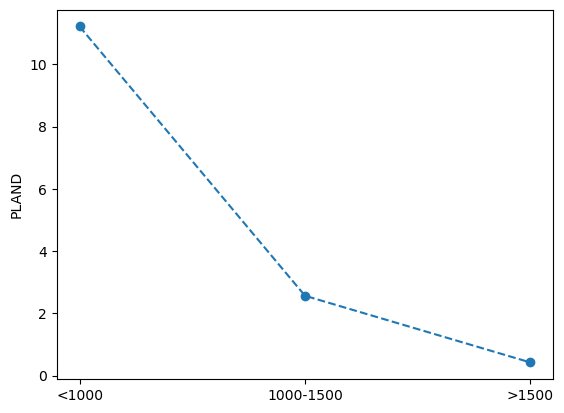

In [ ]:
za.plot_metric("proportion_of_landscape", class_val=URBAN_CLASS_VAL)

In this case we see how the proportion of urbanized landscape (class `1`) becomes zero at highest altitudes.

Finally, in order to visualize such information in space, the zonal statistics can be computed in the form of a geo-data frame with the `compute_zonal_statistics_gdf` method as in:

In [ ]:
zonal_statistics_gdf = za.compute_zonal_statistics_gdf(
    metrics=metrics, class_val=URBAN_CLASS_VAL
)
zonal_statistics_gdf.head()

[########################################] | 100% Completed | 101.02 ms


,edge_density,fractal_dimension_am,proportion_of_landscape,geometry
elev-zone,,,,
1000-1500,7.056761,1.067263,2.564103,"POLYGON ((2563900.000 1160700.000, 2563900.000..."
<1000,26.978462,1.119244,11.212308,"MULTIPOLYGON (((2560900.000 1150500.000, 25607..."
>1500,1.054852,1.000000,0.421941,"MULTIPOLYGON (((2566300.000 1151500.000, 25665..."


/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

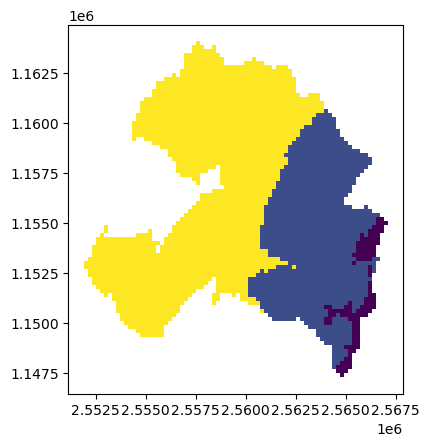

In [ ]:
zonal_statistics_gdf.plot("edge_density")

The computed metrics are essentially the same as those obtained using the `compute_class_metrics_df` or `compute_landscape_metrics_df` (depending on whether a `class_val` argument is provided or not), with an additional column featuring the vector geometry of each zone. This actually corresponds to a geopandas geo-data frame, and as such, we can use [its `geopandas.GeoDataFrame.plot` method](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html) to spatially visualize the value of a metric accross the zones:

/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

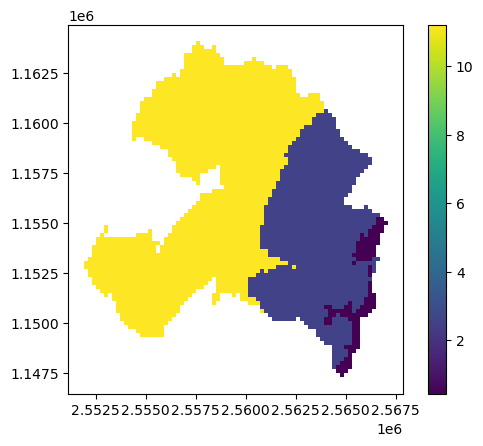

In [ ]:
zonal_statistics_gdf.plot("proportion_of_landscape", legend=True)

### Using labelled raster arrays to define zones

The zones can be defined as NumPy labelled arrays of the same shape of the landscape of interest, where each zone is labelled by a unique integer value, which will be used to identify the zones (i.e., as index).

For instance, in order to compute the metrics over a set of rectangular transects, let us define three transects of 50x50 cells (5x5km) that horizontally traverse our landscape at the latitude of Chatel-St-Denis:

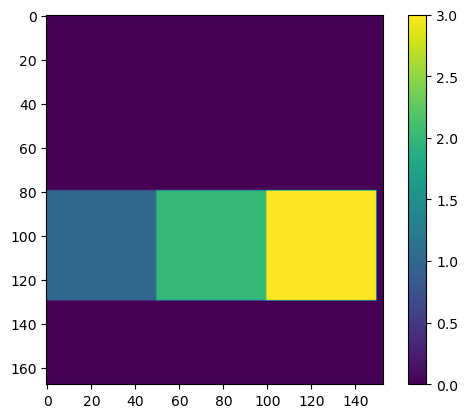

In [ ]:
with rio.open(input_filepath) as src:
    label_arr = np.zeros(src.shape, dtype=np.uint8)

transect_len = 50
for i, transect_start in enumerate(range(0, 150, transect_len), start=1):
    label_arr[80:130, transect_start : transect_start + transect_len] = i

plt.imshow(label_arr)
plt.colorbar()

As we can see, the array labels each transect zone by a unique integer. We can use it as the `zones` argument when initializing a `ZonalAnalysis` instance:

In [ ]:
za = pls.ZonalAnalysis(input_filepath, label_arr)
za.compute_zonal_statistics_gdf(
    metrics=["proportion_of_landscape"], class_val=URBAN_CLASS_VAL
)

[########################################] | 100% Completed | 105.01 ms


,proportion_of_landscape,geometry
zone,,
1.0,14.167813,"POLYGON ((2551850.000 1156050.000, 2551850.000..."
2.0,14.092256,"POLYGON ((2556850.000 1156050.000, 2556850.000..."
3.0,3.752182,"POLYGON ((2561850.000 1156050.000, 2561850.000..."


Note from the geo-data frame above that the label values are used to index the zones. We can override this behaviour by providing a custom `zone_index` argument, e.g., strings that denote that each landscape corresponds to the transect from kilometers 0 to 5, 5 to 10 and 10 to 15 respectivel:

In [ ]:
za = pls.ZonalAnalysis(input_filepath, label_arr, zone_index=["0-5", "5-10", "10-15"])
za.compute_zonal_statistics_gdf(
    metrics=["proportion_of_landscape"], class_val=URBAN_CLASS_VAL
)

[########################################] | 100% Completed | 101.70 ms


,proportion_of_landscape,geometry
zone,,
0-5,14.167813,"POLYGON ((2551850.000 1156050.000, 2551850.000..."
10-15,3.752182,"POLYGON ((2561850.000 1156050.000, 2561850.000..."
5-10,14.092256,"POLYGON ((2556850.000 1156050.000, 2556850.000..."


We can see that the highest proportion of urban land cover is found in the western and central transects, which actually correspond to the town of Chatel-St-Denis.

## Buffer Analysis

In line with the classic concentric models of location and land use, we are often interested in evaluate how the landscape patterns change as we move away from the urban center. This is similar to the "gradient analysis" approach from landscape ecology, which consists in evaluating the spatial variation of the landscape patterns as one moves progressively from the highly-developed urban cores to the less intense suburbs until the rural and natural hinterlands.

To that end, PyLandStats features the `BufferAnalysis` class (which inherits from the `ZonalAnalysis` class), which defines a series of spatial extents for our landscape based on buffers of increasing distances around our feature of interest - in this example, the town of Chatel-St-Denis.

### From Point

We might define a given coordinate as the center of our region of interest (in this example, the town of Chatel-St-Denis) and a series of buffer distances around that point:

In [ ]:
# latitude and longitude of the center of Chatel-St-Denis according to OpenStreetMap
base_geom = Point(6.8992073, 46.52634)
base_geom_crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

# buffer distances (in meters)
buffer_dists = [2000, 4000, 6000]

then, we can use the `BufferAnalysis` class of Pylandstats as in (note that in this case we need to provide the CRS of the geometry using the `base_geom_crs`):

In [ ]:
ba = pls.BufferAnalysis(
    input_filepath, base_geom, buffer_dists, base_geom_crs=base_geom_crs
)

The `BufferAnalysis` instance will automatically generate the three landscapes of interest (one for each buffer distance) by masking the pixels of the input raster:

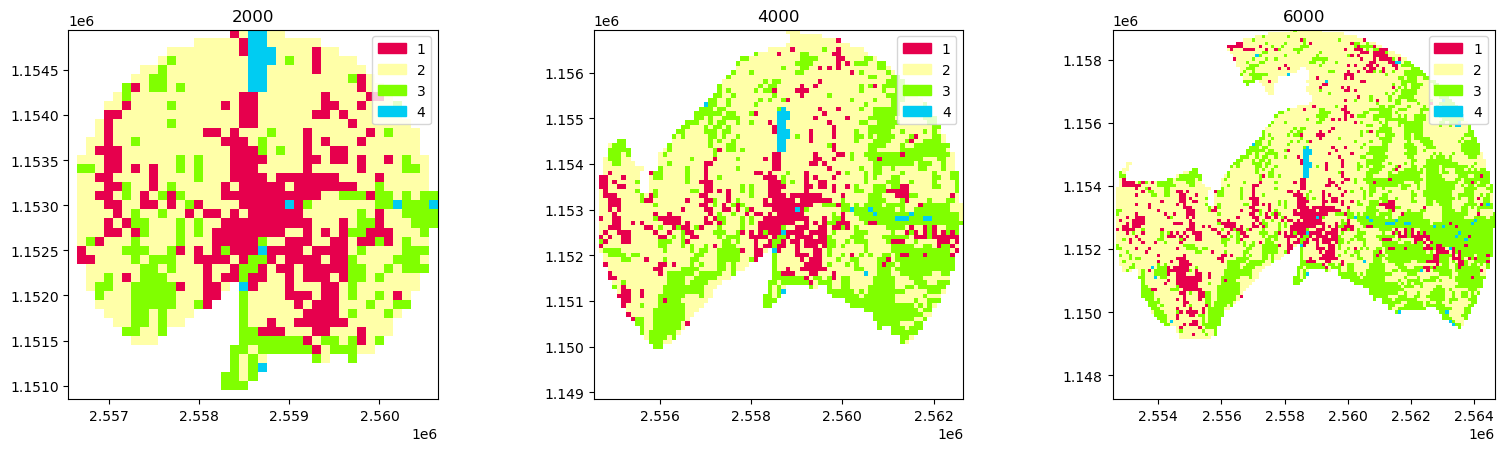

In [ ]:
fig = ba.plot_landscapes(
    cmap=sls.noas04_4_cmap, show_kwargs=dict(norm=sls.noas04_4_norm)
)

Likewise `ZonalAnalysis`, we can compute the landscap metrics for each buffer distance with the `compute_class_metrics_df` and `compute_landscape_metrics_df` methods, e.g.:

In [ ]:
ba.compute_class_metrics_df()

[########################################] | 100% Completed | 3.91 ss


total_area  proportion_of_landscape  number_of_patches  \
class_val buffer_dist                                                           
1         2000              281.0                24.224138                 25   
          4000              469.0                12.727273                 75   
          6000              785.0                10.910354                158   
2         2000              664.0                57.241379                 11   
          4000             2090.0                56.716418                 24   
          6000             4042.0                56.177901                 42   
3         2000              193.0                16.637931                 41   
          4000             1088.0                29.525102                 89   
          6000             2303.0                32.008339                143   
4         2000               22.0                 1.896552                  7   
          4000               38.0                 1.031208                 11   
          6000               65.0                 0.903405                 32   

                       patch_density  largest_patch_index  total_edge  \
class_val buffer_dist                                                   
1         2000              2.155172            16.465517     50900.0   
          4000              2.035278             5.183175     97700.0   
          6000              2.195969             2.654621    170300.0   
2         2000              0.948276            43.793103     76000.0   
          4000              0.651289            45.210312    213100.0   
          6000              0.583739            46.309937    394500.0   
3         2000              3.534483             3.965517     38700.0   
          4000              2.415197            10.719132    151300.0   
          6000              1.987491            20.625434    293500.0   
4         2000              0.603448             1.379310      3800.0   
          4000              0.298507             0.624152      7700.0   
          6000              0.444753             0.319666     16900.0   

                       edge_density  total_core_area  \
class_val buffer_dist                                  
1         2000            43.879310             45.0   
          4000            26.512890             52.0   
          6000            23.669215             88.0   
2         2000            65.517241            186.0   
          4000            57.829037            744.0   
          6000            54.829743           1515.0   
3         2000            33.362069             14.0   
          4000            41.058345            276.0   
          6000            40.792217            678.0   
4         2000             3.275862              2.0   
          4000             2.089552              4.0   
          6000             2.348853              4.0   

                       core_area_proportion_of_landscape  \
class_val buffer_dist                                      
1         2000                                  3.879310   
          4000                                  1.411126   
          6000                                  1.223072   
2         2000                                 16.034483   
          4000                                 20.189959   
          6000                                 21.056289   
3         2000                                  1.206897   
          4000                                  7.489824   
          6000                                  9.423211   
4         2000                                  0.172414   
          4000                                  0.108548   
          6000                                  0.055594   

                       number_of_disjunct_core_areas  ...  \
class_val buffer_dist                                 ...   
1         2000                                     7  ...   
          4000                                    13  ..

Note that the data frames for `BufferAnalysis`, likewise those of `SpatioTemporalAnalysis` or `ZonalAnalysis` (see [above](#customizing-zonal-analysis)) can be customized via by passing the arguments `metrics`, `classes` or `metrics_kws` to the `compute_class_metrics_df` and `compute_landscape_metrics_df` methods.

The `plot_metric` method of `BufferAnalysis` will plot the value of a given metric for each of the buffered landscapes:

[########################################] | 100% Completed | 101.15 ms


<Axes: ylabel='PLAND'>

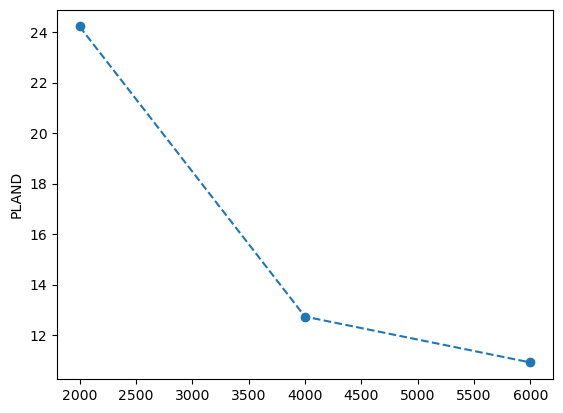

In [ ]:
ba.plot_metric("proportion_of_landscape", class_val=URBAN_CLASS_VAL)

The specific plot above shows how the proportion of landscape (y-axis) occupied by urban land uses diminishes with the buffer distance (x-axis) around the feature of interest (i.e., the city center of Chatel-St-Denis).

To examine more closely how landscape patterns change as we move along the urban-rural gradient, we might actually want to compute the metrics for each of the buffer rings that lie within each pair of increasing buffer distances. For instance, for the buffer distances considered in this example (i.e., 2000, 4000 and 6000), we would like to compute the metrics for the buffer rings that go from 0 to 2000m, 2000 to 4000m and 4000 to 6000m around the center of Chatel-St-Denis).

To that end, we might pass the argument `buffer_rings=True` when instantiating `BufferAnalysis` as in:

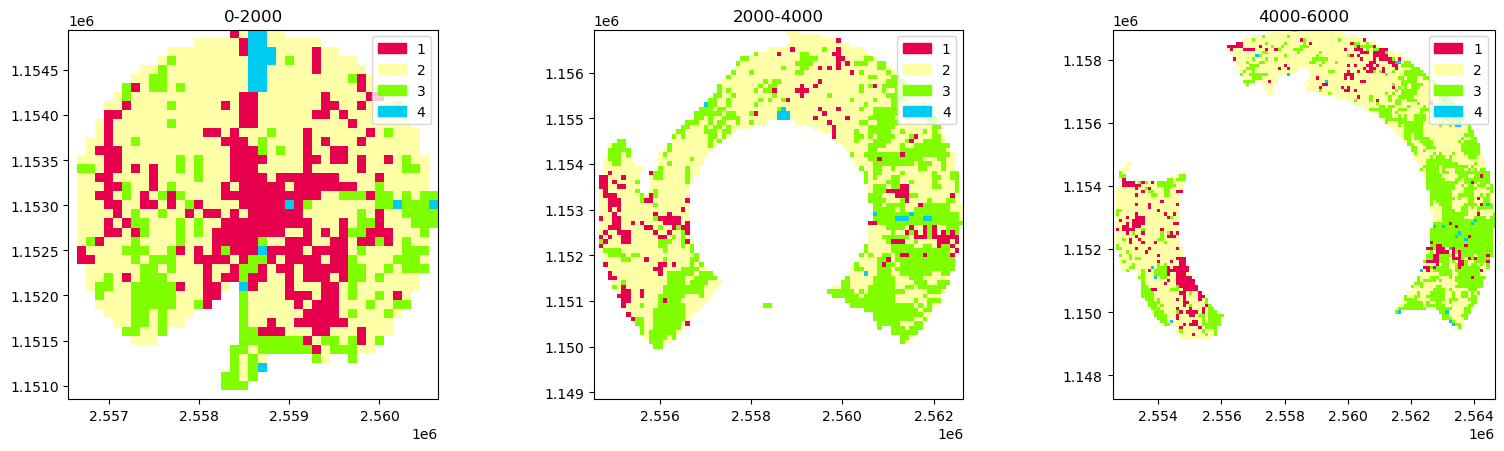

In [ ]:
ba = pls.BufferAnalysis(
    input_filepath,
    base_geom,
    buffer_dists,
    buffer_rings=True,
    base_geom_crs=base_geom_crs,
)
fig = ba.plot_landscapes(
    cmap=sls.noas04_4_cmap, show_kwargs=dict(norm=sls.noas04_4_norm)
)

In [ ]:
ba.compute_class_metrics_df()

[########################################] | 100% Completed | 3.03 ss


/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


total_area  proportion_of_landscape  number_of_patches  \
class_val buffer_dist                                                           
1         0-2000            281.0                24.224138                 25   
          2000-4000         188.0                 7.445545                 52   
          4000-6000         316.0                 9.002849                 93   
2         0-2000            664.0                57.241379                 11   
          2000-4000        1426.0                56.475248                 19   
          4000-6000        1952.0                55.612536                 31   
3         0-2000            193.0                16.637931                 41   
          2000-4000         895.0                35.445545                 59   
          4000-6000        1215.0                34.615385                 64   
4         0-2000             22.0                 1.896552                  7   
          2000-4000          16.0                 0.633663                  6   
          4000-6000          27.0                 0.769231                 21   

                       patch_density  largest_patch_index  total_edge  \
class_val buffer_dist                                                   
1         0-2000            2.155172            16.465517     50900.0   
          2000-4000         2.059406             1.544554     45600.0   
          4000-6000         2.649573             1.794872     70500.0   
2         0-2000            0.948276            43.793103     76000.0   
          2000-4000         0.752475            45.584158    132400.0   
          4000-6000         0.883191            28.888889    176400.0   
3         0-2000            3.534483             3.965517     38700.0   
          2000-4000         2.336634            14.772277    108600.0   
          4000-6000         1.823362            15.584046    137800.0   
4         0-2000            0.603448             1.379310      3800.0   
          2000-4000         0.237624             0.277228      3600.0   
          4000-6000         0.598291             0.085470      8900.0   

                       edge_density  total_core_area  \
class_val buffer_dist                                  
1         0-2000          43.879310             45.0   
          2000-4000       18.059406              7.0   
          4000-6000       20.085470             30.0   
2         0-2000          65.517241            186.0   
          2000-4000       52.435644            521.0   
          4000-6000       50.256410            729.0   
3         0-2000          33.362069             14.0   
          2000-4000       43.009901            260.0   
          4000-6000       39.259259            382.0   
4         0-2000           3.275862              2.0   
          2000-4000        1.425743              1.0   
          4000-6000        2.535613              0.0   

                       core_area_proportion_of_landscape  \
class_val buffer_dist                                      
1         0-2000                                3.879310   
          2000-4000                             0.277228   
          4000-6000                             0.854701   
2         0-2000                               16.034483   
          2000-4000                            20.633663   
          4000-6000                            20.769231   
3         0-2000                                1.206897   
          2000-4000                            10.297030   
          4000-6000                            10.883191   
4         0-2000                                0.172414   
          2000-4000                             0.039604   
          4000-6000                             0.000000   

                       number_of_disjunct_core_areas  ...  \
class_val buffer_dist                                 ...   
1         0-2000                                   7  ...   
          2000-4000                                6  ..

[########################################] | 100% Completed | 104.54 ms


<Axes: ylabel='PLAND'>

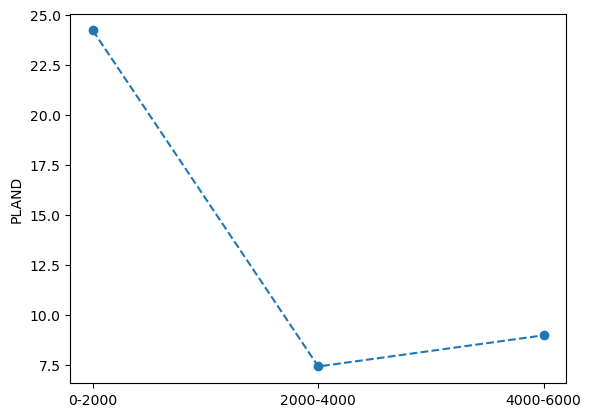

In [ ]:
ba.plot_metric("proportion_of_landscape", class_val=URBAN_CLASS_VAL)

Again, the zonal statistics of a metric can be represented in space with of the `compute_zonal_statistics_gdf` method:

[########################################] | 100% Completed | 101.10 ms


/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


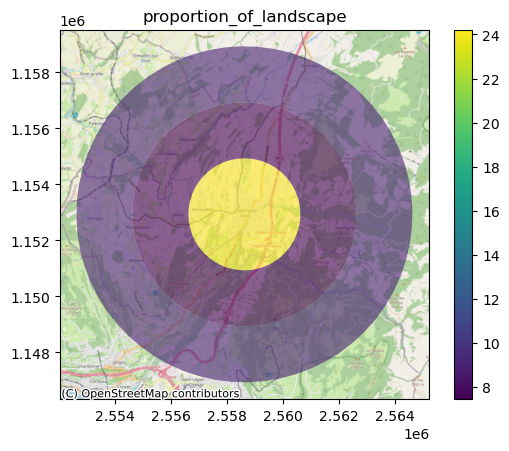

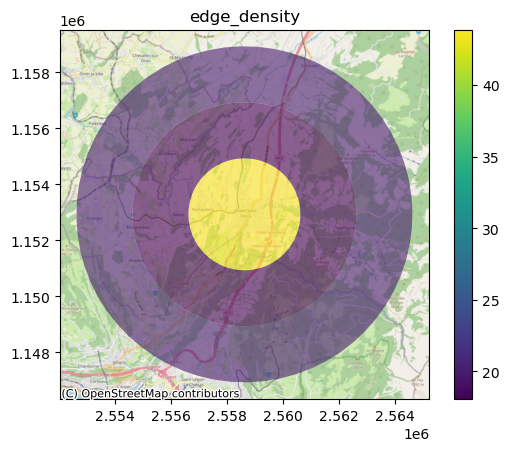

In [ ]:
metrics = ["proportion_of_landscape", "edge_density"]
zonal_statistics_gdf = ba.compute_zonal_statistics_gdf(
    metrics=metrics, class_val=URBAN_CLASS_VAL
)
for metric in metrics:
    ax = zonal_statistics_gdf.plot(metric, alpha=0.6, legend=True)
    ax.set_title(metric)
    cx.add_basemap(
        ax, crs=zonal_statistics_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik
    )

### From Polygon

We might as well build our buffer zones from polygon geometries such as administrative boundaries

<Axes: >

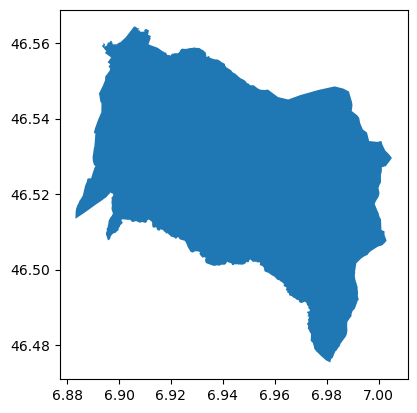

In [ ]:
gdf = ox.geocode_to_gdf("Chatel-St-Denis, Switzerland")
base_geom = gdf.geometry
base_geom.plot()

Note that in this case, since we are working with a GeoSeries that has a CRS defined, we do not need to set it explicitly with the `base_geom_crs` argument.

In [ ]:
base_geom.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Also note that since in this case our base geometry from which we will define buffer zones is already a polygon. Therefore, we might want to start from smaller buffer distances, even from zero, so that we start computing the metrics for the region defined by the polygon itself (in our example, the administrative boundaries)

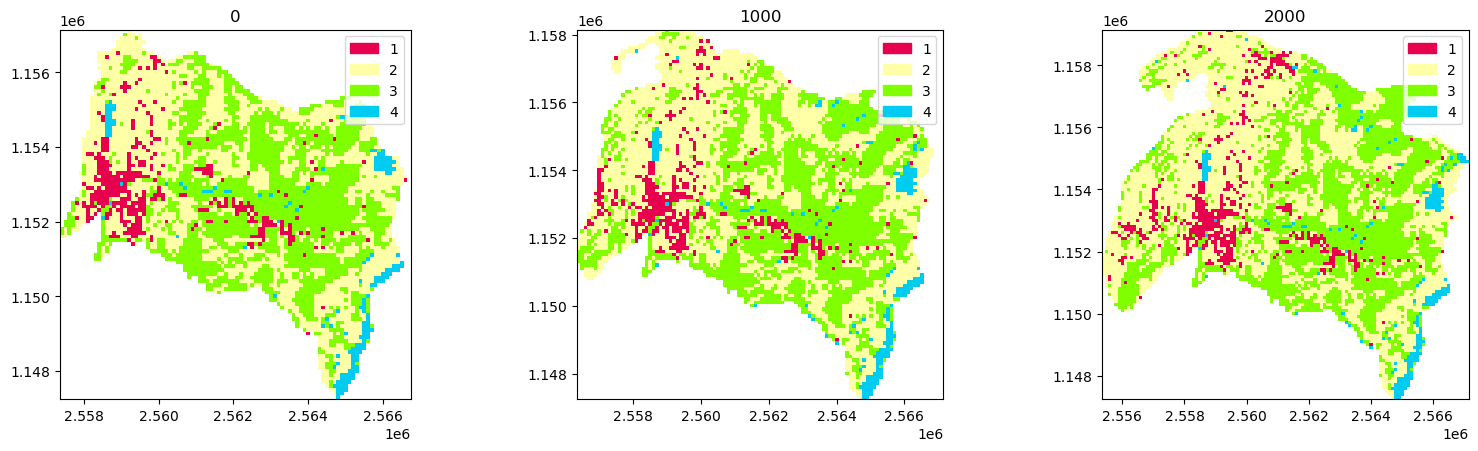

In [ ]:
buffer_dists = [0, 1000, 2000]
ba = pls.BufferAnalysis(input_filepath, base_geom, buffer_dists)
fig = ba.plot_landscapes(
    cmap=sls.noas04_4_cmap, show_kwargs=dict(norm=sls.noas04_4_norm)
)

[########################################] | 100% Completed | 101.33 ms


<Axes: ylabel='PLAND'>

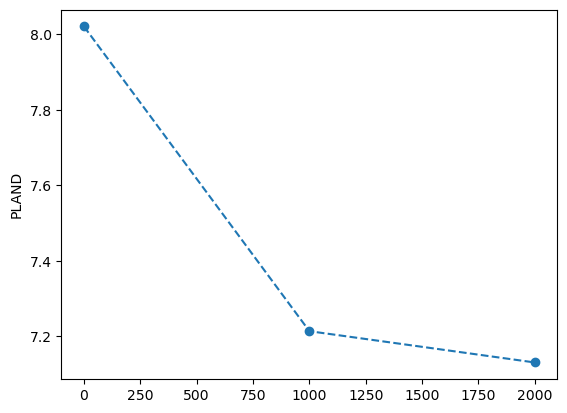

In [ ]:
ba.plot_metric("proportion_of_landscape", class_val=URBAN_CLASS_VAL)

## Zonal Grid Analysis

Another recurrent approach to zonal analysis is to decompose the landscape raster into a coarser grid and compute the landscape metrics for each zone cell. This is the purpose of the `ZonalGridAnalysis` class (which also inherits from `ZonalAnalysis`). We can instantiate it by providing size (in units of the landscape CRS) that we desire in each zone cell as in:

In [ ]:
zone_width, zone_height = 2000, 2000  # in this case, in meters

zga = pls.ZonalGridAnalysis(
    input_filepath,
    zone_width=zone_width,
    zone_height=zone_height,
)

/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


Alternatively, we can instead define the number of zones that we desire in each dimension by means of the `num_zone_rows` and `num_zone_cols` keyword arguments of the initialization method.

The `ZonalGridAnalysis` class will automatically discard all the zone cells that have no data in the original raster. We can visualize the zonal grid (in random grid cell colors) as in:

/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


<Axes: >

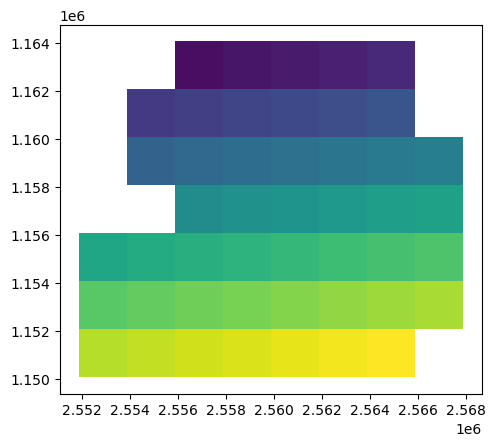

In [ ]:
zga.plot_landscapes()

The `compute_class_metrics_df` and `compute_landscape_metrics_df` class operate exactly like in the other classes:

In [ ]:
zga.compute_class_metrics_df(metrics=metrics, classes=[URBAN_CLASS_VAL])

[########################################] | 100% Completed | 1.10 sms


/home/martibosch/data-science/landscape-connectivity-barcelona/src/pylandstats/pylandstats/multilandscape.py:175: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(


proportion_of_landscape  edge_density
class_val grid_cell                                       
1         2                        12.087912     30.219780
          3                         3.153153     12.162162
          4                         8.433735     25.301205
          9                         3.488372     12.209302
          10                        7.750000     20.500000
          11                        5.000000     15.750000
          12                        7.250000     23.750000
          13                        5.723906     19.865320
          14                        4.166667     16.666667
          17                        6.748466     22.699387
          18                        9.138381     26.109661
          19                        5.750000     18.250000
          20                       13.750000     36.750000
          21                        1.000000      3.500000
          22                        0.411523      1.234568
          26                        2.479339      6.611570
          27                        3.986711     13.953488
          28                       12.500000     30.750000
          29                        0.250000      1.000000
          30                        0.602410      2.409639
          31                        6.666667     20.000000
          32                       26.923077     26.923077
          34                        0.881057      3.083700
          35                        8.500000     23.000000
          36                        2.500000      8.500000
          38                        1.626016      5.691057
          39                        1.333333      5.333333
          40                       14.071856     31.736527
          41                       17.968750     43.489583
          42                       16.331658     38.944724
          43                       43.609023     63.408521
          44                        9.000000     20.750000
          45                        6.250000     15.250000
          46                        1.250000      5.000000
          47                        0.757576      3.030303
          48                        4.166667     14.583333
          49                       23.250000     34.250000
          50                        3.200000      8.400000
          51                       24.427481     38.931298
          52                        1.916933      5.431310
          53                        9.319899     17.128463
          54                        2.255639      8.771930
          55                        1.098901      1.098901
          57                       13.380282     32.394366
          62                        0.632911      2.531646

Note that the data frames are now indexed by a list of tuples that correspond to the row, column location of each zone.

Like in the other zonal analysis classes, the zonal metrics van be represented in space by means of the `compute_zonal_statistics_gdf` method. For instance, we can view the spatial distribution of the edge density at the landscape level as in:

[########################################] | 100% Completed | 102.20 ms


/home/martibosch/data-science/landscape-connectivity-barcelona/src/pylandstats/pylandstats/multilandscape.py:175: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pd.concat(
/home/martibosch/mambaforge/envs/pylandstats/lib/python3.11/site-packages/geopandas/plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


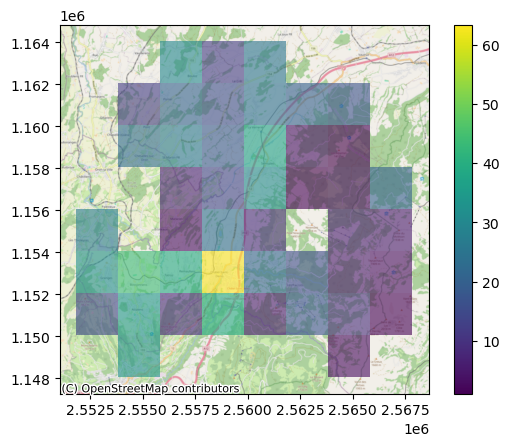

In [ ]:
zonal_statistics_gdf = zga.compute_zonal_statistics_gdf(
    metrics=metrics, class_val=URBAN_CLASS_VAL
)
ax = zonal_statistics_gdf.plot("edge_density", alpha=0.6, legend=True)
cx.add_basemap(
    ax, crs=zonal_statistics_gdf.crs, source=cx.providers.OpenStreetMap.Mapnik
)

## See also

* [SpatioTemporalZonalAnalysis](https://github.com/martibosch/pylandstats-notebooks/blob/main/notebooks/04-spatiotemporal-zonal-analysis.ipynb)